Please run the cells in the order Install->Import->Scenario->Sub-agents->Planner->Run Task. Install takes about half an hour. Restart Runtime when the Install cell has finished running.

# Install

In [1]:
!pip install openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 kB 2.0 MB/s eta 0:00:00


In [2]:
%%capture
!sudo add-apt-repository -y ppa:openjdk-r/ppa
!sudo apt-get purge openjdk-*
!sudo apt-get install openjdk-8-jdk
!sudo apt-get install xvfb xserver-xephyr vnc4server python-opengl ffmpeg
!sudo apt-get install xvfb

In [3]:
%%capture
!pip3 install pyvirtualdisplay
!pip3 install -U colabgymrender
!pip3 install imageio==2.4.1


In [4]:
!pip3 install git+https://github.com/minerllabs/minerl

  Cloning https://github.com/minerllabs/minerl to /tmp/pip-req-build-ckencltq
  Running command git clone --filter=blob:none --quiet https://github.com/minerllabs/minerl /tmp/pip-req-build-ckencltq
  Resolved https://github.com/minerllabs/minerl to commit 40a9e35c086c4dc7959ad473ec765cd4828c4631
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 626.2/626.2 kB 6.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.0/90.0 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 5.9 MB/s eta 0:00:00
   

# Import


In [5]:
import os

import numpy as np
import torch
import torch.nn as nn
import gym
#from gym.wrappers import Monitor
import minerl

import re
import openai

import matplotlib
import matplotlib.pyplot as plt
#%matplotlib inline

from tqdm.notebook import tqdm
from colabgymrender.recorder import Recorder
from pyvirtualdisplay import Display

import logging
logging.disable(logging.ERROR) # reduce clutter, remove if something doesn't work to see the error logs.

import cv2
import glob
import io
import base64
from IPython.display import HTML

from IPython import display as ipythondisplay

np.__version__  # '1.21.6' => that this is reading from our ~/mine_env directory

  from scipy.ndimage.filters import sobel



'1.23.5'

In [6]:
disp = Display(visible=0, backend="xvfb")
disp.start();

# Planner

In [25]:
# import os
# import openai

# openai.api_key = input()

# test = openai.ChatCompletion.create(
#   model="gpt-3.5-turbo",
#   messages=[
#     {"role": "user", "content": "Hello ChatGPT, does this work?"}
#   ]
#   )
# print(test)

In [26]:
context_prompt = """
You are an assistant for the game Minecraft.
I will give you some target object and some knowledge related to the object. Please write the
obtaining of the object as a goal in the standard form.
The standard form of the task is as follows:
{
Task
“description”: specific description of the task
}

To complete the task, you need to play the role of a scheduler, scheduling individual agents to complete the task at different stages of the task.

The following agents are now available for various tasks, each specialising in a different skill:
Tree Chopping Agent: This agent completes the subtask of collecting logs, you can specify the number of logs. Below is an example of scheduling instruction to a Tree Chopper agent, when the agent collects 8 logs the agent will stop working and report on the status of the item bar:
{
“agent_name”: chopping_tree_agent,
“count”: 8
}

Crafting Agent: This agent can do the subtask of crafting items and you can specify the object and number of object to be crafted. Below is an example of s scheduling instruction to a s crafting agent, when the agent has crafted 64 wooden planks the agent will stop working and report on the item bar status:
{
“agent_name”: carfting_agent,
“object”: wooden_planks
“count”: 64
}

Navigation Agent: This agent can move in four directions, south, east, north, and west, and the distance travelled is calculated in chunks (Area of size 16 x 16). The following is an example of scheduling instruction to a navigation agent：
{
“agent_name”: navigation_agent,
“direction”: north,
“distance”: 3
}

You can only schedule one agent at a time. And you can only reschedule or schedule the next agent after an agent completes or fails a subtask. After I answer "Current subtask complete", you answer the next scheduling instruction.
Your scheduling instructions must conform to the format in the example above and be included in the first sentence of the answer.
If you have completed understanding the above, please answer "Yes". I will then enter the task.
"""

task_prompt= """
{
Task
“description”: You need to create a wooden pickaxe from nothing in a survival mode Minecraft world.
}

Only one scheduling instruction can be included in an answer!
You don't need to answer the reason you chose the scheduling instruction, just answer the scheduling instruction.
Your answer must be in strict compliance with the format of the scheduling instructions

When all tasks are completed, only answer: {'done': 1}
"""
subtask_success_prompt = """\nCurrent subtask complete\n"""

In [43]:
import ast

class LLM_planner:
    def __init__(self, key, env) -> None:
        self.key = key
        openai.api_key = self.key
        self.full_text = []
        self.env = env
        self.number_of_iterations = 0
        self.maximum_number_of_iterations = 8
        self.pov_record = []
        self.reward_record = []

    def reset(self):
        self.full_text.clear()
        self.chatWithGPT(role='system', prompt=context_prompt)

    def extract_single_bracket_content(self, s):
        match = re.search(r'(\{.*?\})', s)
        if match:
            return match.group(1)
        else:
            return None

    def chatWithGPT(self, role='user', prompt=''):
        self.full_text.append(
        {"role": role, "content": prompt}
        )

        completion = openai.ChatCompletion.create(
        model = "gpt-3.5-turbo",
        messages = self.full_text
        )

        self.full_text.append(
        {"role": completion.choices[0].message.role, "content": completion.choices[0].message.content}
        )

        # print(completion.choices[0].message.content)

        return completion.choices[0].message.content

    def chopping_tree_agent(self, count=6):
        text = ''
        subtask = ChoppingTreeSubtask(self.env, 6)
        pov_record, reward_record = subtask.runSubtask()
        print('Subtask completion')
        self.pov_record.extend(pov_record)
        self.reward_record.extend(reward_record)
        self.env = subtask.getEnv()
        text += subtask.getAfterCheck()
        text += '\n'
        text += subtask.getInventory()
        # if subtask.getPreCheck == '':

        # else:
        #     text += subtask.getPreCheck()

        return text

    def carfting_agent(self, object='', count=1):
        text = ''
        subtask = CraftingSubtask(self.env)
        if subtask.getPreCheck(object) == '':
            pov_record, reward_record = subtask.runSubtask(object)
            self.pov_record.extend(pov_record)
            self.reward_record.extend(reward_record)
            self.env = subtask.getEnv()
            text += subtask.getAfterCheck()
            text += '\n'
            text += subtask.getInventory()
        else:
            text += subtask.getPreCheck(object)

        return text

    def navigation_agent(self, direction='north', distance=0):
        text = ''
        subtask = NavigationSubtask(self.env, distance, direction)
        if subtask.getPreCheck() == '':
            pov_record, reward_record = subtask.runSubtask()
            self.pov_record.extend(pov_record)
            self.reward_record.extend(reward_record)
            self.env = subtask.getEnv()
            text += subtask.getAfterCheck()
            text += '\n'
            text += subtask.getInventory()
            text += '\n'
            text += subtask.getBiome()
        else:
            text += subtask.getPreCheck()

        return text

    def building_agent(self):
        text = ''
        subtask = BuildingSubtask(self.env)
        if subtask.getPreCheck() == '':
            pov_record, reward_record = subtask.runSubtask()
            self.pov_record.extend(pov_record)
            self.reward_record.extend(reward_record)
            self.env = subtask.getEnv()
            text += subtask.getAfterCheck()
            text += '\n'
            text += subtask.getInventory()
        else:
            text += subtask.getPreCheck()

        return text

    def agent_scheduler(self, response):
        response = ast.literal_eval(response)

        if response['agent_name'] == 'chopping_tree_agent' or response['agent_name'] == "tree_chopping_agent":
            status = self.call_chopping_tree_agent(count=response['count'])
        elif response['agent_name'] == 'crafting_agent':
            status = self.call_carfting_agent(object=response['object'], count=response['count'])
        elif response['agent_name'] == 'navigation_agent':
            status = self.call_navigation_agent(direction=response['direction'], distance=response['distance'])
        else:
            raise Exception("No such agent")

        return status

    def run(self, context_prompt, task_prompt):
        response =  self.chatWithGPT(role='system', prompt=context_prompt)
        response =  self.chatWithGPT(role='user', prompt=task_prompt)

        while self.number_of_iterations < self.maximum_number_of_iterations:
            print(response)
            feedback = ''
            dict_response = ast.literal_eval(response)
            if 'agent_name' in dict_response:
                agent_name = dict_response['agent_name']
                print(agent_name)
                if agent_name == 'chopping_tree_agent' or agent_name == "tree_chopping_agent":
                    feedback += self.chopping_tree_agent(dict_response['count'])

                elif agent_name == 'crafting_agent':
                    feedback += self.carfting_agent(object=dict_response['object'])

                elif agent_name == 'navigation_agent':
                    feedback += self.navigation_agent(self,
                                                        direction=dict_response['direction'],
                                                        distance=int(dict_response['distance']))

                elif agent_name == 'building_agent':
                    feedback += self.building_agent()

                else:
                    feedback += 'Error: No such subagent'

                print('Feedback: ' + str(feedback))
                feedback += '\n No need to explain your reasoning, just give scheduling instructions.'

            elif 'done' in dict_response:
                # Mission accomplished, LLM replies {'done':1}
                return True

            response =  self.extract_single_bracket_content(self.chatWithGPT(role='user', prompt=feedback))

            self.number_of_iterations += 1

#Scenario

In [7]:
from minerl.herobraine.env_specs.human_controls import SimpleHumanEmbodimentEnvSpec
from minerl.herobraine.hero.mc import MS_PER_STEP, STEPS_PER_MS
from minerl.herobraine.hero.handler import Handler
from typing import List

import minerl.herobraine
import minerl.herobraine.hero.handlers as handlers
from minerl.herobraine.env_spec import EnvSpec
from minerl.herobraine.hero.mc import MS_PER_STEP, STEPS_PER_MS, ALL_ITEMS, MC_ITEM_IDS
from minerl.herobraine.hero.mc import INVERSE_KEYMAP
from minerl.herobraine.hero import handlers as H, mc
from minerl.herobraine.hero.handlers.translation import TranslationHandler

MY_TREECHOP_DOC = """
In treechop, the agent must collect 64 `minercaft:log`. This replicates a common scenario in Minecraft, as logs are necessary to craft a large amount of items in the game, and are a key resource in Minecraft.

The agent begins in a forest biome (near many trees) with an iron axe for cutting trees. The agent is given +1 reward for obtaining each unit of wood, and the episode terminates once the agent obtains 64 units.
"""
TREECHOP_LENGTH = 8000
TREECHOP_WORLD_GENERATOR_OPTIONS = """{"coordinateScale":684.412,"heightScale":684.412,"lowerLimitScale":512.0,"upperLimitScale":512.0,"depthNoiseScaleX":200.0,"depthNoiseScaleZ":200.0,"depthNoiseScaleExponent":0.5,"mainNoiseScaleX":80.0,"mainNoiseScaleY":160.0,"mainNoiseScaleZ":80.0,"baseSize":8.5,"stretchY":12.0,"biomeDepthWeight":1.0,"biomeDepthOffset":0.0,"biomeScaleWeight":1.0,"biomeScaleOffset":0.0,"seaLevel":1,"useCaves":false,"useDungeons":false,"dungeonChance":8,"useStrongholds":false,"useVillages":false,"useMineShafts":false,"useTemples":false,"useMonuments":false,"useMansions":false,"useRavines":false,"useWaterLakes":false,"waterLakeChance":4,"useLavaLakes":false,"lavaLakeChance":80,"useLavaOceans":false,"fixedBiome":4,"biomeSize":4,"riverSize":1,"dirtSize":33,"dirtCount":10,"dirtMinHeight":0,"dirtMaxHeight":256,"gravelSize":33,"gravelCount":8,"gravelMinHeight":0,"gravelMaxHeight":256,"graniteSize":33,"graniteCount":10,"graniteMinHeight":0,"graniteMaxHeight":80,"dioriteSize":33,"dioriteCount":10,"dioriteMinHeight":0,"dioriteMaxHeight":80,"andesiteSize":33,"andesiteCount":10,"andesiteMinHeight":0,"andesiteMaxHeight":80,"coalSize":17,"coalCount":20,"coalMinHeight":0,"coalMaxHeight":128,"ironSize":9,"ironCount":20,"ironMinHeight":0,"ironMaxHeight":64,"goldSize":9,"goldCount":2,"goldMinHeight":0,"goldMaxHeight":32,"redstoneSize":8,"redstoneCount":8,"redstoneMinHeight":0,"redstoneMaxHeight":16,"diamondSize":8,"diamondCount":1,"diamondMinHeight":0,"diamondMaxHeight":16,"lapisSize":7,"lapisCount":1,"lapisCenterHeight":16,"lapisSpread":16}"""

NONE = 'none'
OTHER = 'other'

class MyTreechop(SimpleHumanEmbodimentEnvSpec):
    def __init__(self, *args, **kwargs):
        if 'name' not in kwargs:
            kwargs['name'] = 'MyMineRLTreechop-v0'

        super().__init__(*args,
                         max_episode_steps=TREECHOP_LENGTH, reward_threshold=64.0,resolution=[640, 360],
                         **kwargs)

    def create_observables(self) -> List[Handler]:
        return super().create_observables() + [
            handlers.EquippedItemObservation(
                items=ALL_ITEMS,
                mainhand=True,
                offhand=True,
                armor=True,
                _default="air",
                _other="air",
            ),
            handlers.ObservationFromLifeStats(),
            handlers.ObservationFromCurrentLocation(),
            handlers.ObserveFromFullStats("use_item"),
            handlers.ObserveFromFullStats("drop"),
            handlers.ObserveFromFullStats("pickup"),
            handlers.ObserveFromFullStats("break_item"),
            handlers.ObserveFromFullStats("craft_item"),
            handlers.ObserveFromFullStats("mine_block"),
            handlers.ObserveFromFullStats("damage_dealt"),
            handlers.ObserveFromFullStats("entity_killed_by"),
            handlers.ObserveFromFullStats("kill_entity"),
            handlers.FlatInventoryObservation(ALL_ITEMS),
        ]

    def create_actionables(self) -> List[TranslationHandler]:
        """
        Simple envs have some basic keyboard control functionality, but
        not all.
        """
        return [
           H.KeybasedCommandAction(v, v) for v in mc.KEYMAP.values()
        ] + [H.CameraAction()]

    def create_rewardables(self) -> List[Handler]:
        return [
            handlers.RewardForCollectingItems([
                dict(type="log", amount=1, reward=1.0),
            ])
        ]

    def create_agent_start(self) -> List[Handler]:
        return super().create_agent_start() + [
            handlers.SimpleInventoryAgentStart([
                dict(type="oak_log", quantity=4)
            ])
        ]

    def create_agent_handlers(self) -> List[Handler]:
        return [
            handlers.AgentQuitFromPossessingItem([
                dict(type="log", amount=64)]
            )
        ]

    def create_server_world_generators(self) -> List[Handler]:
        return [
            handlers.DefaultWorldGenerator(force_reset="true",
                                           generator_options=TREECHOP_WORLD_GENERATOR_OPTIONS
                                           )
        ]

    def create_server_quit_producers(self) -> List[Handler]:
        return [
            handlers.ServerQuitFromTimeUp(
                (TREECHOP_LENGTH * MS_PER_STEP)),
            handlers.ServerQuitWhenAnyAgentFinishes()
        ]

    def create_server_decorators(self) -> List[Handler]:
        return []

    def create_server_initial_conditions(self) -> List[Handler]:
        return [
            handlers.TimeInitialCondition(
                allow_passage_of_time=False
            ),
            handlers.SpawningInitialCondition(
                allow_spawning=True
            )
        ]

    def determine_success_from_rewards(self, rewards: list) -> bool:
        return sum(rewards) >= self.reward_threshold

    def is_from_folder(self, folder: str) -> bool:
        return folder == 'survivaltreechop'

    def get_docstring(self):
        return MY_TREECHOP_DOC



class MyTreechop2(SimpleHumanEmbodimentEnvSpec):
    def __init__(self, *args, **kwargs):
        if 'name' not in kwargs:
            kwargs['name'] = 'MyMineRLTreechop2-v0'

        super().__init__(*args,
                         max_episode_steps=TREECHOP_LENGTH, reward_threshold=64.0,resolution=[640, 360],
                         **kwargs)

    def create_observables(self) -> List[Handler]:
        return super().create_observables() + [
            handlers.EquippedItemObservation(
                items=ALL_ITEMS,
                mainhand=True,
                offhand=True,
                armor=True,
                _default="air",
                _other="air",
            ),
            handlers.ObservationFromLifeStats(),
            handlers.ObservationFromCurrentLocation(),
            handlers.ObserveFromFullStats("use_item"),
            handlers.ObserveFromFullStats("drop"),
            handlers.ObserveFromFullStats("pickup"),
            handlers.ObserveFromFullStats("break_item"),
            handlers.ObserveFromFullStats("craft_item"),
            handlers.ObserveFromFullStats("mine_block"),
            handlers.ObserveFromFullStats("damage_dealt"),
            handlers.ObserveFromFullStats("entity_killed_by"),
            handlers.ObserveFromFullStats("kill_entity"),
            handlers.ObserveFromFullStats(None),
        ]

    # def create_actionables(self) -> List[TranslationHandler]:
    #     """
    #     Simple envs have some basic keyboard control functionality, but
    #     not all.
    #     """
    #     return [
    #        H.KeybasedCommandAction(v, v) for v in mc.KEYMAP.values()
    #     ] + [H.CameraAction()] + [H.CraftAction(ALL_ITEMS)]

    def create_actionables(self) -> List[Handler]:
        return [
           H.KeybasedCommandAction(v, v) for v in mc.KEYMAP.values()
        ] + [H.CameraAction()] + [H.CraftAction(items=['none'] + ALL_ITEMS + ['other'], _other='other', _default='none')]

    def create_rewardables(self) -> List[Handler]:
        return [
            handlers.RewardForCollectingItems([
                dict(type="log", amount=1, reward=1.0),
            ])
        ]

    def create_agent_start(self) -> List[Handler]:
        return super().create_agent_start() + [
            handlers.SimpleInventoryAgentStart([
                dict(type="oak_log", quantity=4)
            ])
        ]

    def create_agent_handlers(self) -> List[Handler]:
        return [
            handlers.AgentQuitFromPossessingItem([
                dict(type="log", amount=64)]
            )
        ]

    def create_server_world_generators(self) -> List[Handler]:
        return [
            handlers.DefaultWorldGenerator(force_reset="true",
                                           generator_options=TREECHOP_WORLD_GENERATOR_OPTIONS
                                           )
        ]

    def create_server_quit_producers(self) -> List[Handler]:
        return [
            handlers.ServerQuitFromTimeUp(
                (TREECHOP_LENGTH * MS_PER_STEP)),
            handlers.ServerQuitWhenAnyAgentFinishes()
        ]

    def create_server_decorators(self) -> List[Handler]:
        return []

    def create_server_initial_conditions(self) -> List[Handler]:
        return [
            handlers.TimeInitialCondition(
                allow_passage_of_time=False
            ),
            handlers.SpawningInitialCondition(
                allow_spawning=True
            )
        ]

    def determine_success_from_rewards(self, rewards: list) -> bool:
        return sum(rewards) >= self.reward_threshold

    def is_from_folder(self, folder: str) -> bool:
        return folder == 'survivaltreechop'

    def get_docstring(self):
        return MY_TREECHOP_DOC

In [8]:
import gym

from minerl.herobraine.env_spec import EnvSpec

#MINERL_MY_TEST_V0 = MyTestlEnvSpec_2()
MINERL_MY_TREECHOP_V0 = MyTreechop()
MINERL_MY_TREECHOP2_V0 = MyTreechop2()

# Register the envs.
ENVS = [env for env in locals().values() if isinstance(env, EnvSpec)]
for env in ENVS:
    if env.name not in gym.envs.registry.env_specs:
        env.register()

# Sub-agents

## Chopping tree subtask

In [10]:
class CNN(nn.Module):
    def __init__(self, input_shape, output_dim):
        super().__init__()
        n_input_channels = input_shape[0]
        self.cnn = nn.Sequential(
            nn.Conv2d(n_input_channels, 32, kernel_size=8, stride=4),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, output_dim)
        )

    def forward(self, observations):
        return self.cnn(observations)

def dataset_action_batch_to_actions(dataset_actions, camera_margin=5):
    camera_actions = dataset_actions["camera"].squeeze()
    attack_actions = dataset_actions["attack"].squeeze()
    forward_actions = dataset_actions["forward"].squeeze()
    jump_actions = dataset_actions["jump"].squeeze()
    batch_size = len(camera_actions)
    actions = np.zeros((batch_size,), dtype=int)

    for i in range(len(camera_actions)):
        if camera_actions[i][0] < -camera_margin:
            actions[i] = 3
        elif camera_actions[i][0] > camera_margin:
            actions[i] = 4
        elif camera_actions[i][1] > camera_margin:
            actions[i] = 5
        elif camera_actions[i][1] < -camera_margin:
            actions[i] = 6
        elif forward_actions[i] == 1:
            if jump_actions[i] == 1:
                actions[i] = 2
            else:
                actions[i] = 1
        elif attack_actions[i] == 1:
            actions[i] = 0
        else:
            actions[i] = -1
    return actions

In [11]:
from tqdm.notebook import tqdm

class ChoppingTreeSubtask():
    def __init__(self, env, count) -> None:
        self.env = env

        self.camera_angle = 10
        self._actions = [
            dict(attack=1),
            dict(forward=1),
            dict(forward=1, jump=1),
            dict(camera=[-self.camera_angle, 0]),
            dict(camera=[self.camera_angle, 0]),
            dict(camera=[0, self.camera_angle]),
            dict(camera=[0, -self.camera_angle])
        ]

        self.pov_record = []
        self.reward_record = [0]

        self.quantity_of_logs_targeted = count
        self.quantity_of_logs_current = 0
        self.log_reward = 10

        self.T = 1.2
        self.max_step = 1000

        self.model = CNN((3, 64, 64), 7).cuda()
        self.model.load_state_dict(torch.load('/content/choppingTree_2.pth'))
        self.model.eval()

    def runSubtask(self):
        act = self.env.action_space.noop()
        obs, reward, _, _ = self.env.step(act)

        for step in tqdm(range(self.max_step)):
            if self.quantity_of_logs_current < self.quantity_of_logs_targeted:
                # Preprocess
                obs = torch.from_numpy(cv2.resize(obs['pov'], (64, 64)).transpose(2, 0, 1)[None].astype(np.float32) / 255).cuda()
                # Get the logits
                logits = self.model(obs)

                # Turn logits into probabilities
                probabilities = torch.softmax(logits/self.T, dim=1)[0].detach().cpu().numpy()
                # Sample action according to the probabilities
                action = np.random.choice(self._actions, p=probabilities)
                act = self.env.action_space.noop()
                act.update(action)
                act.update(dict(attack=1))

                obs, reward, _, _ = self.env.step(act)
                self.pov_record.append(obs['pov'])

                # Get the number of logs on the current agent
                if obs['inventory']['oak_log'].item() > self.quantity_of_logs_current:
                    self.quantity_of_logs_current = obs['inventory']['oak_log'].item()
                    print(str(obs['inventory']['oak_log'].item()) + ' oak logs')
                    # Get reward, 1 log = 10 rewards
                    self.reward_record.append(self.reward_record[-1] + self.log_reward)
                else:
                    self.reward_record.append(self.reward_record[-1])

            else:
                break

        return self.pov_record, self.reward_record

    def getEnv(self):
        return self.env

    def getRecord(self):
        return self.pov_record, self.reward_record

    def getInventory(self):
        text = "Inventory: {"
        act = self.env.action_space.noop()
        obs, reward, _, _ = self.env.step(act)

        for i, v in obs['inventory'].items():
            if v != 0:
                text += "'" + str(i) + "': " + str(v) + ", "
        text += "}"

        return text

    def getPreCheck(self):
        return ''

    def getAfterCheck(self):
        if self.quantity_of_logs_current >= self.quantity_of_logs_targeted:
            return "\nCurrent subtask complete\n"
        else:
            return "\nError: agent cannot collect enough logs within the time limit\n"

In [12]:
# env = gym.make('MyMineRLTreechop-v0')
# env.seed(10)
# obs = env.reset()
# plt.imshow(obs['pov'])

In [13]:
# subtask = ChoppingTreeSubtask(env, 8)
# pov_record, reward_record = subtask.runSubtask()

In [14]:
# subtask.getInventory()

In [15]:
# import os
# # import cv2

# file_path='saveVideo.mp4'
# size=(320,180)
# fps = 30

# fourcc = cv2.VideoWriter_fourcc(*'mp4v')
# videoWriter = cv2.VideoWriter(file_path,fourcc,fps,size)

# for item in pov_record:
#     b, g, r = cv2.split(item)
#     img = cv2.merge([r, g, b])
#     img = cv2.resize(img, size)
#     #img = cv2.imread(item)
#     videoWriter.write(img)

# videoWriter.release()

## Naviagtion subtask

In [16]:
class NavigationSubtask():
    def __init__(self, env, distance, direction) -> None:
        self.env = env

        self.camera_angle = 10
        self._button_actions = [
            dict(forward=1),
            # dict(back=1),
            dict(left=1),
            dict(right=1),
            dict(forward=1, jump=1),
            dict(forward=1, sprint=1),
        ]
        self._camera_actions = [
            dict(),
            dict(camera=[-self.camera_angle, 0]),
            dict(camera=[self.camera_angle, 0]),
            dict(camera=[0, self.camera_angle]),
            dict(camera=[0, -self.camera_angle]),
        ]

        self.pov_record = []
        self.reward_record = [0]

        self.coordinate_current = None

        # [-205, 208] is the defualt spawn point, 16 is width or length of 1 chunck
        if direction == 'north':
            self.coordinate_targeted = [-205, 208+distance*16]
        elif direction == 'south':
            self.coordinate_targeted = [-205, 208-distance*16]
        elif direction == 'west':
            self.coordinate_targeted = [-205+distance*16, 208]
        elif direction == 'east':
            self.coordinate_targeted = [-205-distance*16, 208]
        else:
            self.coordinate_targeted = [0, 0]

        self.min_distance = None
        self.last_distance = None

        self.T = 1.2
        self.max_step = 2000

        self.model = Cnn().cuda()
        self.model.load_state_dict(torch.load('/content/navigation_4.pth'))
        self.model.eval()

    def get_action(self, ca, ba, t=1.2):
        ca_probabilities = torch.softmax(ca/t, dim=1)[0].detach().cpu().numpy()
        ba_probabilities = torch.softmax(ba/t, dim=1)[0].detach().cpu().numpy()
        # Sample action according to the probabilities
        camera_action = np.random.choice(self._camera_actions, p=ca_probabilities)
        button_action = np.random.choice(self._button_actions, p=ca_probabilities)

        act = self.env.action_space.noop()
        act.update(camera_action)
        act.update(button_action)
        # act.update(dict(jump=1))

        ci = self._camera_actions.index(camera_action)
        bi = self._button_actions.index(button_action)

        return act, ci, bi

    def get_reward(self, obs):
        location = np.array([obs['location_stats']['xpos'].item(), obs['location_stats']['zpos'].item()])
        self.coordinate_current = location
        destination = self.coordinate_targeted
        destination = np.array(destination)
        distance = np.sqrt(np.sum((location - destination) ** 2))
        if self.min_distance == None:
            self.min_distance = distance
            self.last_distance = distance
            return 0

        if self.min_distance - distance > 0.1:
            self.min_distance = distance
            self.last_distance = distance
            return 5
        elif distance < 10:
            self.min_distance = None
            self.last_distance = None
            return 100
        elif distance - self.last_distance > 0.1:
            self.last_distance = distance
            return -0.5
        else:
            self.last_distance = distance
            return 0

    def runSubtask(self):
        act = self.env.action_space.noop()
        obs, reward, _, _ = self.env.step(act)

        for step in tqdm(range(self.max_step)):
            pov = obs["pov"]
            pov = cv2.resize(pov, (64, 64)).astype(np.float32)
            state = pov.transpose(2, 0, 1) / 255.0
            state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

            camera_output, buttons_ouput = self.model(state)
            minerl_action, ci, bi = self.get_action(camera_output, buttons_ouput, t=self.T)
            obs, reward, done, info = self.env.step(minerl_action)
            self.pov_record.append(obs['pov'])

            reward = self.get_reward(obs)
            self.reward_record.append(self.reward_record[-1] + reward)

            if reward == 100:
                done = True

            if done:
                break

        return self.pov_record, self.reward_record

    def getEnv(self):
        return self.env

    def getRecord(self):
        return self.pov_record, self.reward_record

    def getInventory(self):
        text = "Inventory: {'"
        act = self.env.action_space.noop()
        obs, reward, _, _ = self.env.step(act)

        for i, v in obs['inventory'].items():
            if v != 0:
                text += str(i) + "': 'quantity': " + str(v) + ", "
        text += "}"

        return text

    def getBiome(self):
        # See https://minecraft.fandom.com/wiki/Biome/ID
        text = "Biome: {'biome': "
        act = self.env.action_space.noop()
        obs, reward, _, _ = self.env.step(act)

        if obs['location_stats']['biome_id'] == 0:
            text += "'Plains'}"
        elif obs['location_stats']['biome_id'] == 7:
            text += "'Forest'}"
        elif obs['location_stats']['biome_id'] == 7:
            text += "'Desert'}"
        else:
            text += "'Plains'}"

        return text

    def getPreCheck(self):
        return ''

    def getAfterCheck(self):
        return "\nCurrent subtask complete\n"

In [17]:
import torch
import torch.nn as nn
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Cnn(nn.Module):
    def __init__(self, input_shape=(3, 64, 64)):
        super().__init__()
        n_input_channels = input_shape[0]
        self.cnn = nn.Sequential(
            nn.Conv2d(n_input_channels, 32, kernel_size=8, stride=4),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
        )

        self.flat_size = 1024
        self.camera = nn.Linear(512, 5)
        self.buttons = nn.Linear(512, 6)

    def forward(self, observations):
        cnn_output = self.cnn(observations)

        camera_output = self.camera(cnn_output)
        buttons_ouput = self.buttons(cnn_output)

        return camera_output, buttons_ouput

    def initial_hidden_state(self):
        h0 = torch.zeros(2, 1, 512).to(device)
        c0 = torch.zeros(2, 1, 512).to(device)
        hidden = (h0, c0)
        return hidden

    def preprocess(self, img, img_size=(64, 64)):
        pov = cv2.resize(img, img_size).astype(np.float32)
        state = pov.transpose(2, 0, 1) / 255.0
        state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

        return state

    def get_result(self, camera_logits, button_logits, t=1.2):
        camera_probabilities = torch.softmax(camera_logits/t, dim=1)[0].detach().cpu().numpy()
        button_probabilities = torch.softmax(button_logits/t, dim=1)[0].detach().cpu().numpy()

        camera_action = np.random.choice(5, p=camera_probabilities)
        button_action = np.random.choice(6, p=camera_probabilities)

        return camera_action, button_action


In [18]:
# subtask2 = NavigationSubtask(env, 3, 'north')
# pov_record2, reward_record2 = subtask2.runSubtask()

In [19]:
# import os
# # import cv2

# file_path='saveVideo.mp4'
# size=(320,180)
# fps = 30

# fourcc = cv2.VideoWriter_fourcc(*'mp4v')
# videoWriter = cv2.VideoWriter(file_path,fourcc,fps,size)

# for item in pov_record2:
#     b, g, r = cv2.split(item)
#     img = cv2.merge([r, g, b])
#     img = cv2.resize(img, size)
#     #img = cv2.imread(item)
#     videoWriter.write(img)

# videoWriter.release()

## Crafting Subagent

In [45]:
class CraftingSubtask():
    def __init__(self, env) -> None:
        self.env = env
        self.numberOfPlanks = 0
        self.numberOfStick = 0
        self.numberOfTable = 0
        self.numberOfPickaxe = 0
        self.record = []
        self.rewards = [0]
        self.al = False

    # def materialChecking(self):
    #     if obs['inventory']['oak_log'] >= 8:
    #         return True
    #     return False

    def runSubtask(self, item):
        record = []
        rewards = [0]
        # wooden_planks_script = self.getWoodenPlanksScript()
        # wooden_sticks_script = self.getWoodenStickScript()
        # carfting_table_script = self.getCarftingTableScript()
        # placing_table_script = self.getPlacingTableScript()
        # carfting_wooden_pickaxe = self.getCarftingWoodenPickaxeScript()
        # collecting_table_script = self.getCollectingTableScript()
        all_script = []
        if item == 'planks' or item == 'oak_planks' or item == 'wooden_planks':
            all_script.append(self.getWoodenPlanksScript())
        elif item == 'stick':
            all_script.append(self.getWoodenStickScript())
        elif item == 'crafting_table' or item == 'work_bench':
            all_script.append(self.getCraftingTableScript())
        elif item == 'wooden_pickaxe':
            all_script.append(self.getPlacingTableScript())
            all_script.append(self.getCraftingWoodenPickaxeScript())
            all_script.append(self.getCollectingTableScript())

        # all_script.append(self.getWoodenPlanksScript())
        # all_script.append(self.getWoodenStickScript())
        # all_script.append(self.getCraftingTableScript())
        # all_script.append(self.getPlacingTableScript())
        # all_script.append(self.getCraftingWoodenPickaxeScript())
        # all_script.append(self.getCollectingTableScript())

        for i in tqdm(range(len(all_script))):
            for script in all_script[i]:
                ac = self.env.action_space.noop()
                ac = self.script_to_action(script, ac)
                obs, reward, done, info = self.env.step(ac)
                record.append(obs['pov'])
                reward = self.getReward(obs)
                # print(reward)
                rewards.append(rewards[-1] + reward)

        self.record = record
        self.rewards = rewards

        return record, rewards

    def getReward(self, obs):
        reward = 0
        if obs['inventory']['oak_planks'] - self.numberOfPlanks > 0:
            reward += (obs['inventory']['oak_planks'] - self.numberOfPlanks) * 1
            self.numberOfPlanks = obs['inventory']['oak_planks']
        if obs['inventory']['stick'] - self.numberOfStick > 0:
            reward += (obs['inventory']['stick'] - self.numberOfStick) * 10
            self.numberOfStick = obs['inventory']['stick']
        if obs['inventory']['crafting_table'] - self.numberOfTable > 0:
            reward += (obs['inventory']['crafting_table'] - self.numberOfTable) * 30
            self.numberOfTable = obs['inventory']['crafting_table']
        if obs['inventory']['wooden_pickaxe'] - self.numberOfPickaxe > 0:
            reward += (obs['inventory']['wooden_pickaxe'] - self.numberOfPickaxe) * 50
            self.numberOfPickaxe = obs['inventory']['wooden_pickaxe']

        return reward

    def script_to_action(self, script, ac):
        if isinstance(script, dict):
            ac.update(script)
            return ac
        else:
            ac[script] = 1
            return ac

    def getWoodenPlanksScript(self):
        wooden_planks_script = []
        wooden_planks_script.append(dict())
        wooden_planks_script.append(dict(inventory=1))
        wooden_planks_script.append(dict(camera=[-3, 3]))
        wooden_planks_script.append(dict(attack=1))
        wooden_planks_script.append(dict(camera=[-4, -23]))
        wooden_planks_script.append(dict(attack=1, sneak=1))
        wooden_planks_script.append(dict())
        wooden_planks_script.append(dict())
        wooden_planks_script.append(dict())
        wooden_planks_script.append(dict())
        wooden_planks_script.append(dict(camera=[0, 42]))
        wooden_planks_script.append(dict(attack=1, sneak=1))
        wooden_planks_script.append(dict())
        wooden_planks_script.append(dict())
        wooden_planks_script.append(dict())
        wooden_planks_script.append(dict())
        wooden_planks_script.append(dict(inventory=1))

        return wooden_planks_script

    def getWoodenStickScript(self):
        wooden_sticks_script = []
        wooden_sticks_script.append(dict())
        wooden_sticks_script.append(dict(inventory=1))
        wooden_sticks_script.append(dict(camera=[-3, 3]))
        wooden_sticks_script.append(dict(attack=1))
        wooden_sticks_script.append(dict(camera=[-4, -13]))
        wooden_sticks_script.append(dict(attack=1))
        wooden_sticks_script.append(dict())
        wooden_sticks_script.append(dict(attack=1))
        wooden_sticks_script.append(dict())
        wooden_sticks_script.append(dict())
        wooden_sticks_script.append(dict())
        wooden_sticks_script.append(dict())
        wooden_sticks_script.append(dict(camera=[0, 32]))
        wooden_sticks_script.append(dict(attack=1, sneak=1))
        wooden_sticks_script.append(dict())
        wooden_sticks_script.append(dict())
        wooden_sticks_script.append(dict())
        wooden_sticks_script.append(dict())
        wooden_sticks_script.append(dict(inventory=1))

        return wooden_sticks_script

    def getCraftingTableScript(self):
        carfting_table_script = []
        carfting_table_script.append(dict())
        carfting_table_script.append(dict(inventory=1))
        carfting_table_script.append(dict(camera=[-3, 3]))
        carfting_table_script.append(dict(attack=1))
        carfting_table_script.append(dict(camera=[-4, -16]))
        carfting_table_script.append(dict(attack=1))
        carfting_table_script.append(dict())
        carfting_table_script.append(dict())
        carfting_table_script.append(dict())
        carfting_table_script.append(dict())
        carfting_table_script.append(dict(camera=[0, 35]))
        carfting_table_script.append(dict(attack=1, sneak=1))
        carfting_table_script.append(dict())
        carfting_table_script.append(dict())
        carfting_table_script.append(dict())
        carfting_table_script.append(dict())
        carfting_table_script.append(dict(inventory=1))

        return carfting_table_script

    def getPlacingTableScript(self):
        placing_table_script = []
        placing_table_script.append(dict())
        for i in range(4):
            placing_table_script.append(dict(back=1))
        placing_table_script.append(dict(camera=[180, 0]))
        placing_table_script.append(dict(camera=[-45, 90]))
        placing_table_script.append('hotbar.7')
        placing_table_script.append(dict(use=1))
        placing_table_script.append(dict())
        placing_table_script.append(dict())
        placing_table_script.append(dict())
        placing_table_script.append(dict())
        placing_table_script.append(dict(use=1))
        placing_table_script.append(dict())
        placing_table_script.append(dict())
        placing_table_script.append(dict())
        placing_table_script.append(dict())
        placing_table_script.append(dict())

        return placing_table_script

    def getCraftingWoodenPickaxeScript(self):
        carfting_wooden_pickaxe = []
        carfting_wooden_pickaxe.append(dict(camera=[-7, -10]))
        carfting_wooden_pickaxe.append(dict(attack=1))
        carfting_wooden_pickaxe.append(dict())
        carfting_wooden_pickaxe.append(dict())
        carfting_wooden_pickaxe.append(dict())
        carfting_wooden_pickaxe.append(dict())
        carfting_wooden_pickaxe.append(dict(camera=[0, 29]))
        carfting_wooden_pickaxe.append(dict(attack=1, sneak=1))
        carfting_wooden_pickaxe.append(dict())
        carfting_wooden_pickaxe.append(dict())
        carfting_wooden_pickaxe.append(dict())
        carfting_wooden_pickaxe.append(dict())
        carfting_wooden_pickaxe.append('hotbar.6')
        carfting_wooden_pickaxe.append(dict(inventory=1))

        return carfting_wooden_pickaxe

    def getCollectingTableScript(self):
        collecting_table_script = []
        collecting_table_script.append(dict())
        for i in range(4):
            collecting_table_script.append(dict(forward=1))
        for i in range(80):
            collecting_table_script.append(dict(attack=1))
        collecting_table_script.append(dict(forward=1))
        for i in range(16):
            collecting_table_script.append(dict())

        return collecting_table_script

    def getInventory(self):
        text = "Inventory: {"
        act = self.env.action_space.noop()
        obs, reward, _, _ = self.env.step(act)

        for i, v in obs['inventory'].items():
            if v != 0:
                text += "'" + str(i) + "': " + str(v) + ", "
        text += "}"

        return text

    def getPreCheck(self, item):
        act = self.env.action_space.noop()
        obs, reward, _, _ = self.env.step(act)
        # if obs['inventory']['oak_log'] >= 8:
        #     return ''
        # return 'Error: Not enough logs to start crafting subtasks'

        if item == 'planks' or item == 'oak_planks' or item == 'wooden_planks':
            if obs['inventory']['oak_log'] >= 1:
                return ''
            else:
                return 'Error: Not enough logs to start crafting subtasks'
        elif item == 'stick':
            if obs['inventory']['oak_planks'] >= 2:
                return ''
            else:
                return 'Error: Not enough oak_planks to start crafting subtasks'
        elif item == 'crafting_table' or item == 'work_bench':
            if obs['inventory']['oak_planks'] >= 4:
                return ''
            else:
                return 'Error: Not enough oak_planks to start crafting subtasks'
        elif item == 'wooden_pickaxe':
            if obs['inventory']['stick'] >= 2:
                return ''
            else:
                return 'Error: Not enough stick to start crafting subtasks'
        else:
            return 'Error: No such object'

    def getAfterCheck(self):
        return "\nCurrent subtask complete\n"

    def getEnv(self):
        return self.env

In [21]:
# craft = CraftingSubtask(env)
# pov_record, reward_record = craft.runSubtask()

In [22]:
# craft.getInventory()

## Building subtask

In [23]:
from tqdm.notebook import tqdm

class BuildingSubtask():
    def __init__(self, env, count) -> None:
        self.env = env

        self.camera_angle = 10
        self._actions = [
            dict(use=1),
            dict(forward=1),
            dict(forward=1, jump=1),
            dict(camera=[-self.camera_angle, 0]),
            dict(camera=[self.camera_angle, 0]),
            dict(camera=[0, self.camera_angle]),
            dict(camera=[0, -self.camera_angle]),
            dict(attack=1)
        ]

        self.pov_record = []

        self.T = 1.2
        self.max_step = 9000

        self.model = CNN2((3, 64, 64), 8).cuda().cuda()
        self.model.load_state_dict(torch.load('/content/buildingAgent2.pth'))
        self.model.eval()

    def runSubtask(self):
        act = self.env.action_space.noop()
        obs, reward, _, _ = self.env.step(act)

        for step in tqdm(range(self.max_step)):
            if self.quantity_of_logs_current < self.quantity_of_logs_targeted:
                # Preprocess
                obs = torch.from_numpy(cv2.resize(obs['pov'], (64, 64)).transpose(2, 0, 1)[None].astype(np.float32) / 255).cuda()
                # Get the logits
                logits = self.model(obs)

                # Turn logits into probabilities
                probabilities = torch.softmax(logits/self.T, dim=1)[0].detach().cpu().numpy()
                # Sample action according to the probabilities
                action = np.random.choice(self._actions, p=probabilities)
                act = self.env.action_space.noop()
                act.update(action)
                act.update(dict(attack=1))

                obs, reward, _, _ = self.env.step(act)
                self.pov_record.append(obs['pov'])

                # Get the number of logs on the current agent
                if obs['inventory']['oak_log'].item() > self.quantity_of_logs_current:
                    self.quantity_of_logs_current = obs['inventory']['oak_log'].item()
                    print(str(obs['inventory']['oak_log'].item()) + ' oak logs')
                    # Get reward, 1 log = 10 rewards
                    self.reward_record.append(self.reward_record[-1] + self.log_reward)
                else:
                    self.reward_record.append(self.reward_record[-1])

            else:
                break

        return self.pov_record, self.reward_record

    def getEnv(self):
        return self.env

    def getRecord(self):
        return self.pov_record, self.reward_record

    def getInventory(self):
        text = "Inventory: {"
        act = self.env.action_space.noop()
        obs, reward, _, _ = self.env.step(act)

        for i, v in obs['inventory'].items():
            if v != 0:
                text += "'" + str(i) + "': " + str(v) + ", "
        text += "}"

        return text

    def getPreCheck(self):
        act = self.env.action_space.noop()
        obs, reward, _, _ = self.env.step(act)
        if obs['inventory']['oak_planks'] >= 60:
            return ''
        return 'Error: Not enough oak_planks to start crafting subtasks'

    def getAfterCheck(self):
        return "\nCurrent subtask complete\n"

In [24]:
class CNN2(nn.Module):
    def __init__(self, input_shape, output_dim):
        super().__init__()
        n_input_channels = input_shape[0]
        self.cnn = nn.Sequential(
            nn.Conv2d(n_input_channels, 32, kernel_size=8, stride=4),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )

    def forward(self, observations):
        return self.cnn(observations)

# Run Task

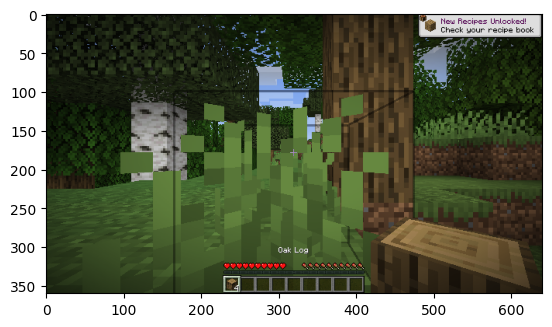

In [46]:
env = gym.make('MyMineRLTreechop-v0')
env.seed(10)
obs = env.reset()
plt.imshow(obs['pov'])

In [ ]:
key = input('Input OpenAI API key here: ')

In [47]:
planner = LLM_planner(key, env)
result = planner.run(context_prompt, task_prompt)
if result:
    print('Mission accomplished')
else:
    print('Mission interrupted')

{ "agent_name": "crafting_agent", "object": "wooden_pickaxe", "count": 1 }
crafting_agent
Feedback: Error: Not enough stick to start crafting subtasks
{ "agent_name": "tree_chopping_agent", "count": 2 }
tree_chopping_agent


  0%|          | 0/1000 [00:00<?, ?it/s]

4 oak logs
5 oak logs
6 oak logs
Subtask completion
Feedback: 
Current subtask complete

Inventory: {'oak_log': 6, }
{ "agent_name": "crafting_agent", "object": "wooden_planks", "count": 12 }
crafting_agent


  0%|          | 0/1 [00:00<?, ?it/s]

Feedback: 
Current subtask complete

Inventory: {'oak_planks': 24, }
{ "agent_name": "crafting_agent", "object": "stick", "count": 4 }
crafting_agent


  0%|          | 0/1 [00:00<?, ?it/s]

Feedback: 
Current subtask complete

Inventory: {'oak_planks': 20, 'stick': 8, }
{ "agent_name": "crafting_agent", "object": "wooden_pickaxe", "count": 1 }
crafting_agent


  0%|          | 0/3 [00:00<?, ?it/s]

Feedback: 
Current subtask complete

Inventory: {'oak_planks': 20, 'stick': 8, }
{'done': 1}
Mission accomplished
